<a href="https://colab.research.google.com/github/mikakia/Project-in-HealthCare/blob/Unlabeled-Data/Core_Indicators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [262]:
import requests
import zipfile
import io
import pandas as pd
import  missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

# Link to the dataset information: https://opendata.paho.org/en/core-indicators/download-dataset

## Load csv file from github

In [263]:
#  Download the branch ZIP from GitHub
url = "https://github.com/mikakia/Project-in-HealthCare/archive/refs/heads/Unlabeled-Data.zip"
response = requests.get(url)
response.raise_for_status()

# Open outer ZIP in memory
with zipfile.ZipFile(io.BytesIO(response.content)) as outer_zip:

    # Read the inner ZIP file as bytes
    with outer_zip.open("Project-in-HealthCare-Unlabeled-Data/PAHO-Core-Indicators-2025-20251001.zip") as inner_file:
        inner_bytes = inner_file.read()

    # Open inner ZIP from bytes
    with zipfile.ZipFile(io.BytesIO(inner_bytes)) as inner_zip:

        # List files inside the inner ZIP
        print(inner_zip.namelist())

        # Open the CSV inside inner ZIP
        csv_name = "PAHO-Core-Indicators-2025-20251001.csv"
        with inner_zip.open(csv_name) as f:
            df_original = pd.read_csv(f)


['PAHO-Core-Indicators-2025-20251001.csv']


/tmp/ipython-input-2157285227.py:22: DtypeWarning: Columns (10,13,14,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv(f)


# Exploring dataset

## Checking shape and info

In [264]:
df_original.shape


(337970, 27)

In [265]:
df_original.head()

,paho_indicator_id,indicator_name,nombre_indicador,spatial_dim_type,spatial_dim,spatial_dim_en,spatial_dim_es,time_dim_type,time_dim,numeric_value,...,data_provider_type,data_provider_specific,data_secondary_source,type_statistics,public_private,public_private_sp,source_url,preliminary,published_at,accessed_at
0,439,Adolescent fertility rate (births per 1 000 wo...,Tasa de fecundidad en adolescentes (nacimiento...,COUNTRY,ABW,Aruba,Aruba,YEAR,1995,43.239,...,Other,"United Nations, Department of Economic and Soc...",PAHO Core Indicators,NaN,NaN,NaN,https://population.un.org/wpp/Download/Standar...,NaN,2024-07-11,2024-07-11
1,439,Adolescent fertility rate (births per 1 000 wo...,Tasa de fecundidad en adolescentes (nacimiento...,COUNTRY,ABW,Aruba,Aruba,YEAR,1996,41.874,...,Other,"United Nations, Department of Economic and Soc...",PAHO Core Indicators,NaN,NaN,NaN,https://population.un.org/wpp/Download/Standar...,NaN,2024-07-11,2024-07-11
2,439,Adolescent fertility rate (births per 1 000 wo...,Tasa de fecundidad en adolescentes (nacimiento...,COUNTRY,ABW,Aruba,Aruba,YEAR,1997,40.793,...,Other,"United Nations, Department of Economic and Soc...",PAHO Core Indicators,NaN,NaN,NaN,https://population.un.org/wpp/Download/Standar...,NaN,2024-07-11,2024-07-11
3,439,Adolescent fertility rate (births per 1 000 wo...,Tasa de fecundidad en adolescentes (nacimiento...,COUNTRY,ABW,Aruba,Aruba,YEAR,1998,38.001,...,Other,"United Nations, Department of Economic and Soc...",PAHO Core Indicators,NaN,NaN,NaN,https://population.un.org/wpp/Download/Standar...,NaN,2024-07-11,2024-07-11
4,439,Adolescent fertility rate (births per 1 000 wo...,Tasa de fecundidad en adolescentes (nacimiento...,COUNTRY,ABW,Aruba,Aruba,YEAR,1999,40.549,...,Other,"United Nations, Department of Economic and Soc...",PAHO Core Indicators,NaN,NaN,NaN,https://population.un.org/wpp/Download/Standar...,NaN,2024-07-11,2024-07-11


In [266]:
df_original.describe()

,paho_indicator_id,time_dim,numeric_value,low,high,preliminary
count,337970.000000,337970.000000,3.379700e+05,37958.000000,37958.000000,164326.000000
mean,426.417735,2005.705503,1.697733e+03,31.547701,48.219479,0.003992
std,338.607132,14.339629,2.282492e+04,29.166295,37.349059,0.063057
min,1.000000,1970.000000,-9.990000e+02,0.000000,1.799000,0.000000
25%,222.000000,1998.000000,6.860036e+00,7.800000,16.400000,0.000000
50%,348.000000,2008.000000,2.945825e+01,22.100000,44.199598,0.000000
75%,416.000000,2017.000000,1.122563e+02,50.000000,74.689298,0.000000
max,1321.000000,2030.000000,1.026602e+07,488.636545,844.761771,1.000000


In [267]:
df_original.corr(numeric_only=True)

,paho_indicator_id,time_dim,numeric_value,low,high,preliminary
paho_indicator_id,1.000000,-0.159167,0.031295,0.279576,0.363384,-0.067482
time_dim,-0.159167,1.000000,0.002712,0.063417,0.124423,0.072773
numeric_value,0.031295,0.002712,1.000000,0.963113,0.971042,-0.004403
low,0.279576,0.063417,0.963113,1.000000,0.884750,NaN
high,0.363384,0.124423,0.971042,0.884750,1.000000,NaN
preliminary,-0.067482,0.072773,-0.004403,NaN,NaN,1.000000


Checking the unique values of the most correlated features

In [268]:
print("\n\n Low: \n", df_original["low"].unique())
print("\n\n Numeric value: \n", df_original["numeric_value"].unique())
print("\n\n Value as a  string: \n", df_original["value_as_string"].unique())
print("\n\n High: \n", df_original["high"].unique())



 Low: 
 [        nan 15.215      14.42       ...  1.68965552  1.64115367
  1.59690516]


 Numeric value: 
 [43.239      41.874      40.793      ... 88.23       97.44165802
 99.88      ]


 Value as a  string: 
 ['43.24' '41.87' '40.79' ... 93.9 92.9 99.88]


 High: 
 [        nan 20.841      19.802      ...  3.39260202  3.21271026
  3.21469435]


In [269]:
df_original.columns.tolist()

['paho_indicator_id',
 'indicator_name',
 'nombre_indicador',
 'spatial_dim_type',
 'spatial_dim',
 'spatial_dim_en',
 'spatial_dim_es',
 'time_dim_type',
 'time_dim',
 'numeric_value',
 'value_as_string',
 'low',
 'high',
 'technical_note',
 'nota_tecnica',
 'data_source_type',
 'data_source_specific',
 'data_provider_type',
 'data_provider_specific',
 'data_secondary_source',
 'type_statistics',
 'public_private',
 'public_private_sp',
 'source_url',
 'preliminary',
 'published_at',
 'accessed_at']

In [270]:
df_original.head()

,paho_indicator_id,indicator_name,nombre_indicador,spatial_dim_type,spatial_dim,spatial_dim_en,spatial_dim_es,time_dim_type,time_dim,numeric_value,...,data_provider_type,data_provider_specific,data_secondary_source,type_statistics,public_private,public_private_sp,source_url,preliminary,published_at,accessed_at
0,439,Adolescent fertility rate (births per 1 000 wo...,Tasa de fecundidad en adolescentes (nacimiento...,COUNTRY,ABW,Aruba,Aruba,YEAR,1995,43.239,...,Other,"United Nations, Department of Economic and Soc...",PAHO Core Indicators,NaN,NaN,NaN,https://population.un.org/wpp/Download/Standar...,NaN,2024-07-11,2024-07-11
1,439,Adolescent fertility rate (births per 1 000 wo...,Tasa de fecundidad en adolescentes (nacimiento...,COUNTRY,ABW,Aruba,Aruba,YEAR,1996,41.874,...,Other,"United Nations, Department of Economic and Soc...",PAHO Core Indicators,NaN,NaN,NaN,https://population.un.org/wpp/Download/Standar...,NaN,2024-07-11,2024-07-11
2,439,Adolescent fertility rate (births per 1 000 wo...,Tasa de fecundidad en adolescentes (nacimiento...,COUNTRY,ABW,Aruba,Aruba,YEAR,1997,40.793,...,Other,"United Nations, Department of Economic and Soc...",PAHO Core Indicators,NaN,NaN,NaN,https://population.un.org/wpp/Download/Standar...,NaN,2024-07-11,2024-07-11
3,439,Adolescent fertility rate (births per 1 000 wo...,Tasa de fecundidad en adolescentes (nacimiento...,COUNTRY,ABW,Aruba,Aruba,YEAR,1998,38.001,...,Other,"United Nations, Department of Economic and Soc...",PAHO Core Indicators,NaN,NaN,NaN,https://population.un.org/wpp/Download/Standar...,NaN,2024-07-11,2024-07-11
4,439,Adolescent fertility rate (births per 1 000 wo...,Tasa de fecundidad en adolescentes (nacimiento...,COUNTRY,ABW,Aruba,Aruba,YEAR,1999,40.549,...,Other,"United Nations, Department of Economic and Soc...",PAHO Core Indicators,NaN,NaN,NaN,https://population.un.org/wpp/Download/Standar...,NaN,2024-07-11,2024-07-11


### Dropping unnecessary columns


1.   Removing the columns containing the names in spanish
2.   "value_as_string" containing the numeric values in string format
3.   the last 4 columns containing information about: URL of the source, Mark for preliminary data, Date of publication at the source, Date of accessed by PAHO
4.   "high" and "low" (the uncertaintity indicator which not all of the indicatros have)







In [271]:
colstodrop = ["nombre_indicador", "spatial_dim_es", "nota_tecnica", "public_private_sp",
              "source_url", "preliminary", "published_at", "accessed_at", "value_as_string", "low", "high"]
df = df_original.drop(columns=colstodrop)

In [272]:
df.columns.tolist()

['paho_indicator_id',
 'indicator_name',
 'spatial_dim_type',
 'spatial_dim',
 'spatial_dim_en',
 'time_dim_type',
 'time_dim',
 'numeric_value',
 'technical_note',
 'data_source_type',
 'data_source_specific',
 'data_provider_type',
 'data_provider_specific',
 'data_secondary_source',
 'type_statistics',
 'public_private']

### Checking the unique values of some columns to better understand the structure of the data

In [273]:
print("Data Source type: \n", df["data_source_type"].unique())
#print("\n\n Indicator Name: \n", df["indicator_name"].unique())
print("\n\n Data Provider type: \n", df["data_provider_type"].unique())
#print("\n\n Data Provider specific: \n", df["data_provider_specific"].unique())
print("\n\n'Spatial dim type: \n", df["spatial_dim_type"].unique())
print("\n\n Time dim type: \n", df["time_dim_type"].unique())
print("\n\n Data Secondary Source: \n", df["data_secondary_source"].unique())
print("\n\n Type Statistics: \n", df["type_statistics"].unique())
print("\n\n Public Private: \n", df["public_private"].unique())


Data Source type: 
 ['Other' 'Public Health Surveillance' 'Estimation' nan
 'Administrative health registry, facility reporting system (e.g. national database of hospital discharges)'
 'Civil registration'
 'Specific information register (e.g. human resources, birth registries, perinatal registry, other)'
 'Survey' 'Special study' 'Census' 'Disease specific register']


 Data Provider type: 
 ['Other' 'Ministry of Health / National Health Agency' nan
 'National Statistics Institute / National Statistics Office']


'Spatial dim type: 
 ['COUNTRY']


 Time dim type: 
 ['YEAR']


 Data Secondary Source: 
 ['PAHO Core Indicators']


 Type Statistics: 
 [nan 'Crude (unadjusted)' 'Predicted' 'Corrected (adjusted)']


 Public Private: 
 [nan 'Public sector only' 'Both Public and Private Sector'
 'Public sector and partial private' 'Private sector only' 'Not specified']


In [274]:
print("\n\n Technical Note: \n", df["technical_note"].unique())



 Technical Note: 
 [nan
 'All residents, officially registered at the Registry Office have Universal Access and Coverage for health care through the General Health Insurance'
 'The indicator includes live births and stillbirths.'
 'Percentages are based on antenatal women who were at 36 weeks gestation.'
 'Numerator corresponds to the total number of pregnant women with 4 controls and more. Denominator is the total number of live births. The data comes from institutional administrative records.'
 'Data correspond to administrative records of the number of pregnant women with 4 prenatal check-ups attended by health personnel.'
 "Data was collected from the Island's Polyclinics and Private Institution, Labour Ward Census, Birth and Death registry"
 'Due to the passage of Hurricane Beryl, the records from 2 clinics in the District of Carriacou & Petit Martinique were inaccessible in 2023.'
 'Data entered is best estimate drawing from nursing reports.'
 'Percentage of women between 15-49

### Checking missing values

In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337970 entries, 0 to 337969
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   paho_indicator_id       337970 non-null  int64  
 1   indicator_name          337970 non-null  object 
 2   spatial_dim_type        337970 non-null  object 
 3   spatial_dim             337970 non-null  object 
 4   spatial_dim_en          337970 non-null  object 
 5   time_dim_type           337970 non-null  object 
 6   time_dim                337970 non-null  int64  
 7   numeric_value           337970 non-null  float64
 8   technical_note          896 non-null     object 
 9   data_source_type        337308 non-null  object 
 10  data_source_specific    336839 non-null  object 
 11  data_provider_type      337418 non-null  object 
 12  data_provider_specific  337250 non-null  object 
 13  data_secondary_source   337970 non-null  object 
 14  type_statistics     

In [276]:
df.isnull().sum()

,0
paho_indicator_id,0
indicator_name,0
spatial_dim_type,0
spatial_dim,0
spatial_dim_en,0
time_dim_type,0
time_dim,0
numeric_value,0
technical_note,337074
data_source_type,662


In [277]:
print("\n\n Type of statistics: \n", df["type_statistics"].unique())



 Type of statistics: 
 [nan 'Crude (unadjusted)' 'Predicted' 'Corrected (adjusted)']


In [278]:
print("\n\n Public Private: \n", df["public_private"].unique())



 Public Private: 
 [nan 'Public sector only' 'Both Public and Private Sector'
 'Public sector and partial private' 'Private sector only' 'Not specified']


<Axes: >

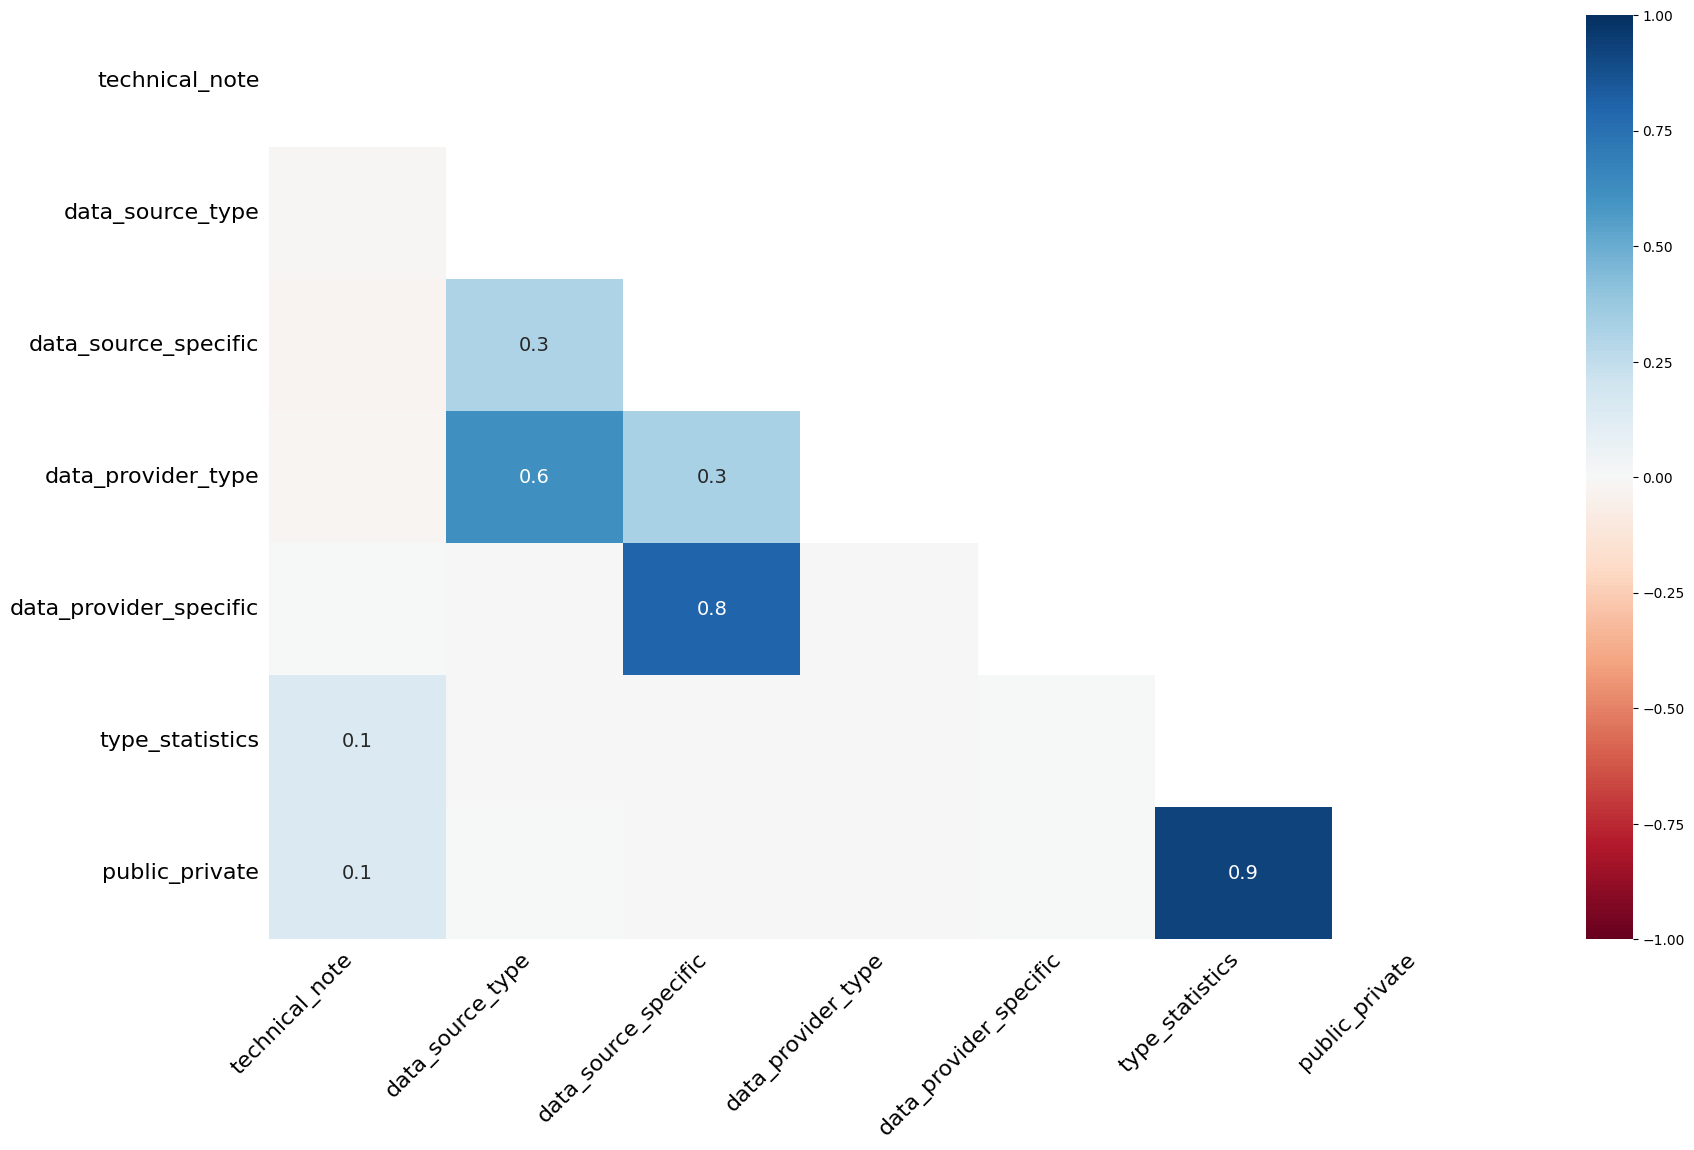

In [279]:
msno.heatmap(df)

<Axes: >

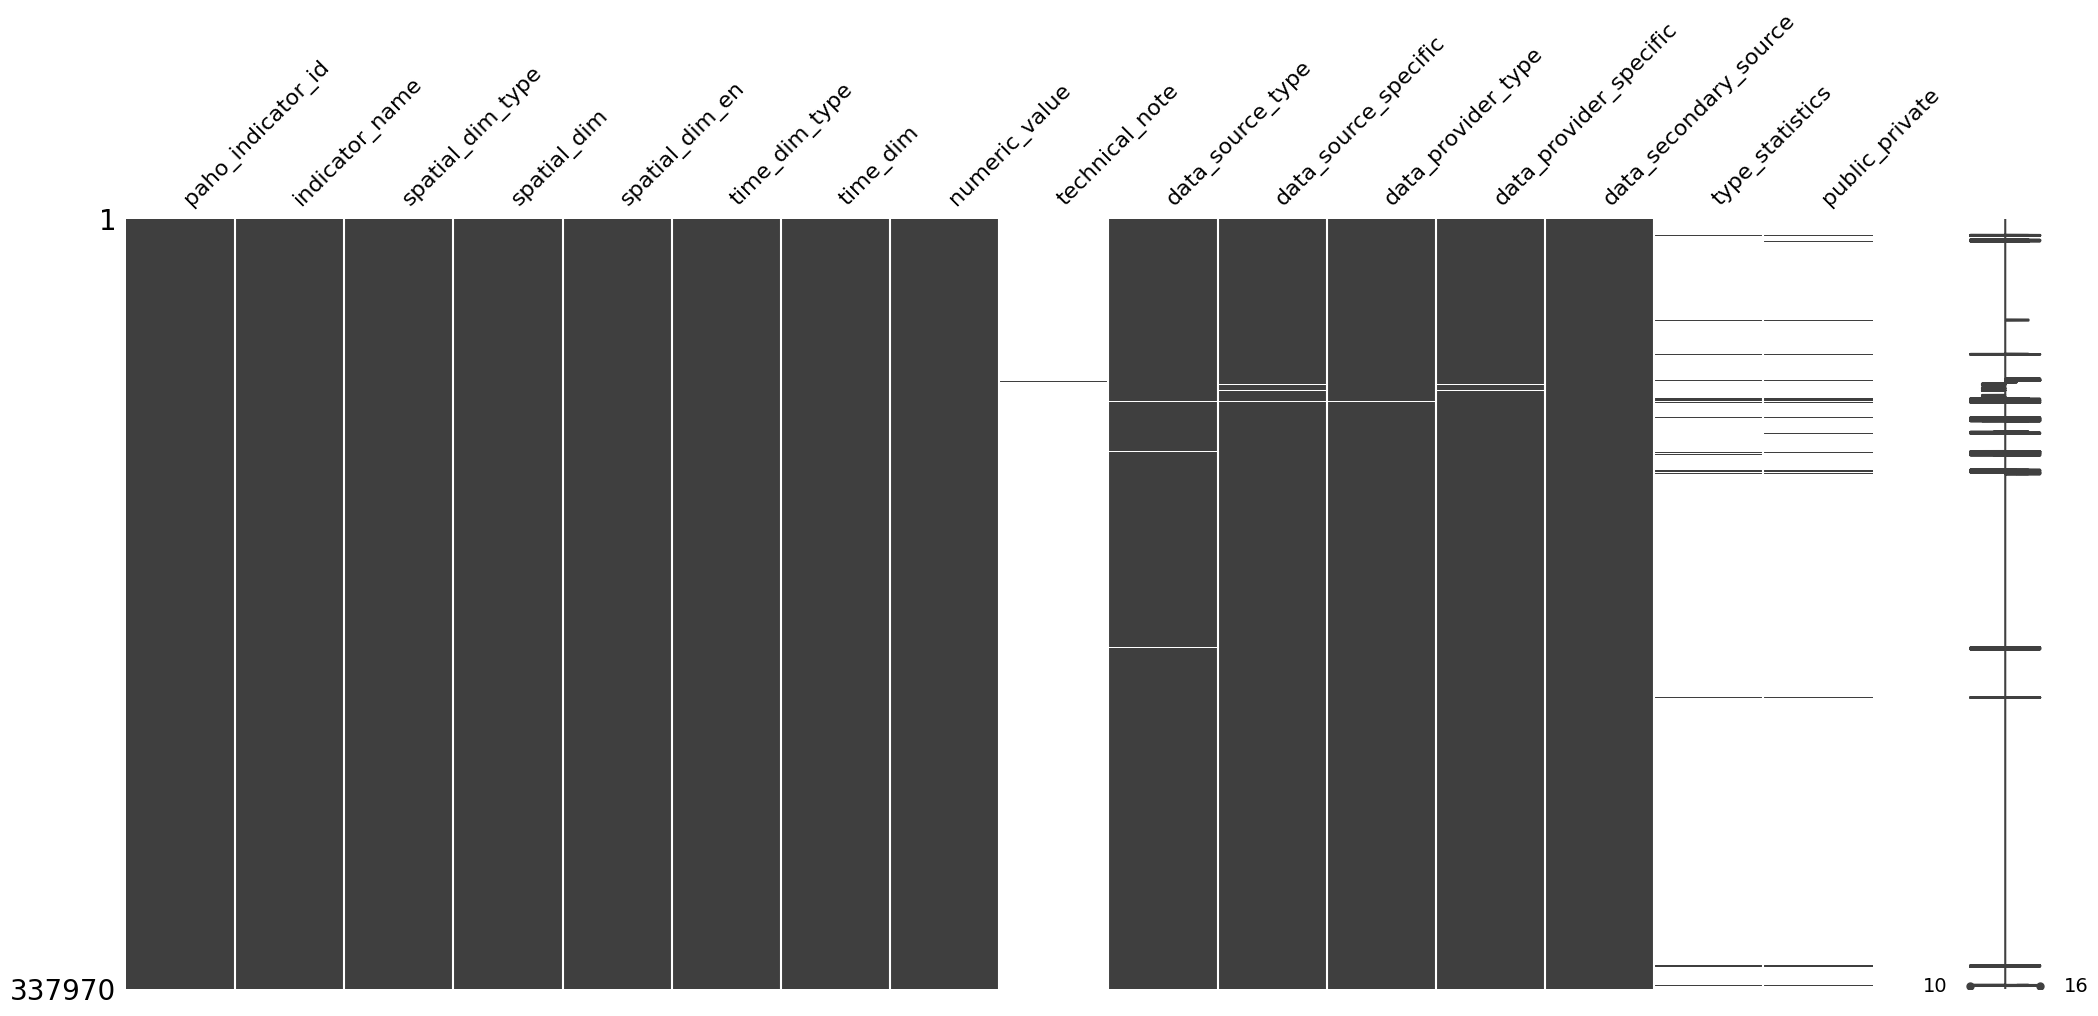

In [280]:
msno.matrix(df)

In [281]:
df[df["technical_note"].notna()]

,paho_indicator_id,indicator_name,spatial_dim_type,spatial_dim,spatial_dim_en,time_dim_type,time_dim,numeric_value,technical_note,data_source_type,data_source_specific,data_provider_type,data_provider_specific,data_secondary_source,type_statistics,public_private
6984,422,Antenatal care coverage -at least 4 visits (%),COUNTRY,ABW,Aruba,YEAR,2024,95.0,"All residents, officially registered at the Re...",Estimation,Estimation,Ministry of Health / National Health Agency,Ministry of Health of Aruba,PAHO Core Indicators,Predicted,Both Public and Private Sector
6996,422,Antenatal care coverage -at least 4 visits (%),COUNTRY,ARG,Argentina,YEAR,2022,75.3,The indicator includes live births and stillbi...,Specific information register (e.g. human reso...,Sistema Informático Perinatal para la Gestión ...,Ministry of Health / National Health Agency,Ministerio de Salud de Argentina. Dirección Na...,PAHO Core Indicators,Crude (unadjusted),Both Public and Private Sector
7020,422,Antenatal care coverage -at least 4 visits (%),COUNTRY,BHS,Bahamas,YEAR,2019,81.2,Percentages are based on antenatal women who w...,"Administrative health registry, facility repor...",Primary Health Care,Ministry of Health / National Health Agency,Ministry of Health of Bahamas. Department of P...,PAHO Core Indicators,Crude (unadjusted),Public sector only
7066,422,Antenatal care coverage -at least 4 visits (%),COUNTRY,BOL,Bolivia (the Plurinational State of),YEAR,2021,81.5,Numerator corresponds to the total number of p...,"Administrative health registry, facility repor...",Sistema Nacional de Información en Salud y Vig...,Ministry of Health / National Health Agency,Ministerio de Salud de Bolivia (Estado Plurina...,PAHO Core Indicators,Crude (unadjusted),Both Public and Private Sector
7067,422,Antenatal care coverage -at least 4 visits (%),COUNTRY,BOL,Bolivia (the Plurinational State of),YEAR,2022,81.3,Data correspond to administrative records of t...,"Administrative health registry, facility repor...",Sistema Nacional de Información en Salud y Vig...,Ministry of Health / National Health Agency,Ministerio de Salud y Deportes. Bolivia (Estad...,PAHO Core Indicators,Crude (unadjusted),Public sector only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336226,284,Women accessing prenatal care since the first ...,COUNTRY,BOL,Bolivia (the Plurinational State of),YEAR,2023,66.6,Women with prenatal care registered before the...,"Administrative health registry, facility repor...",Sistema Nacional de Información en Salud y Vig...,Ministry of Health / National Health Agency,Ministerio de Salud y Deportes. Bolivia (Estad...,PAHO Core Indicators,Crude (unadjusted),Public sector only
336590,284,Women accessing prenatal care since the first ...,COUNTRY,TCA,Turks and Caicos Islands,YEAR,2023,24.4,The numerator used is the number of women with...,"Administrative health registry, facility repor...","Administrative health registry, facility repor...",Other,Primary healthcare clinics. Turks and Caicos I...,PAHO Core Indicators,Crude (unadjusted),Public sector only
336591,284,Women accessing prenatal care since the first ...,COUNTRY,TCA,Turks and Caicos Islands,YEAR,2024,24.8,The numerator used is the number of women with...,"Administrative health registry, facility repor...","Administrative health registry, facility repor...",Ministry of Health / National Health Agency,Ministry of Health of Turks and Caicos Islands...,PAHO Core Indicators,Crude (unadjusted),Public sector only
336625,284,Women accessing prenatal care since the first ...,COUNTRY,URY,Uruguay,YEAR,2023,86.2,It is considered the first trimester until <14...,Specific information register (e.g. human reso...,Certificado de Nacido Vivo y Sistema informáti...,Ministry of Health / National Health Agency,Ministerio de Salud de Uruguay. Dirección Gene...,PAHO Core Indicators,Corrected (adjusted),Both Public and Private Sector


In [282]:
df[df["type_statistics"].notna() == False].head()

,paho_indicator_id,indicator_name,spatial_dim_type,spatial_dim,spatial_dim_en,time_dim_type,time_dim,numeric_value,technical_note,data_source_type,data_source_specific,data_provider_type,data_provider_specific,data_secondary_source,type_statistics,public_private
0,439,Adolescent fertility rate (births per 1 000 wo...,COUNTRY,ABW,Aruba,YEAR,1995,43.239,NaN,Other,"World Population Prospects 2024, Online Edition",Other,"United Nations, Department of Economic and Soc...",PAHO Core Indicators,NaN,NaN
1,439,Adolescent fertility rate (births per 1 000 wo...,COUNTRY,ABW,Aruba,YEAR,1996,41.874,NaN,Other,"World Population Prospects 2024, Online Edition",Other,"United Nations, Department of Economic and Soc...",PAHO Core Indicators,NaN,NaN
2,439,Adolescent fertility rate (births per 1 000 wo...,COUNTRY,ABW,Aruba,YEAR,1997,40.793,NaN,Other,"World Population Prospects 2024, Online Edition",Other,"United Nations, Department of Economic and Soc...",PAHO Core Indicators,NaN,NaN
3,439,Adolescent fertility rate (births per 1 000 wo...,COUNTRY,ABW,Aruba,YEAR,1998,38.001,NaN,Other,"World Population Prospects 2024, Online Edition",Other,"United Nations, Department of Economic and Soc...",PAHO Core Indicators,NaN,NaN
4,439,Adolescent fertility rate (births per 1 000 wo...,COUNTRY,ABW,Aruba,YEAR,1999,40.549,NaN,Other,"World Population Prospects 2024, Online Edition",Other,"United Nations, Department of Economic and Soc...",PAHO Core Indicators,NaN,NaN


## Visualize data

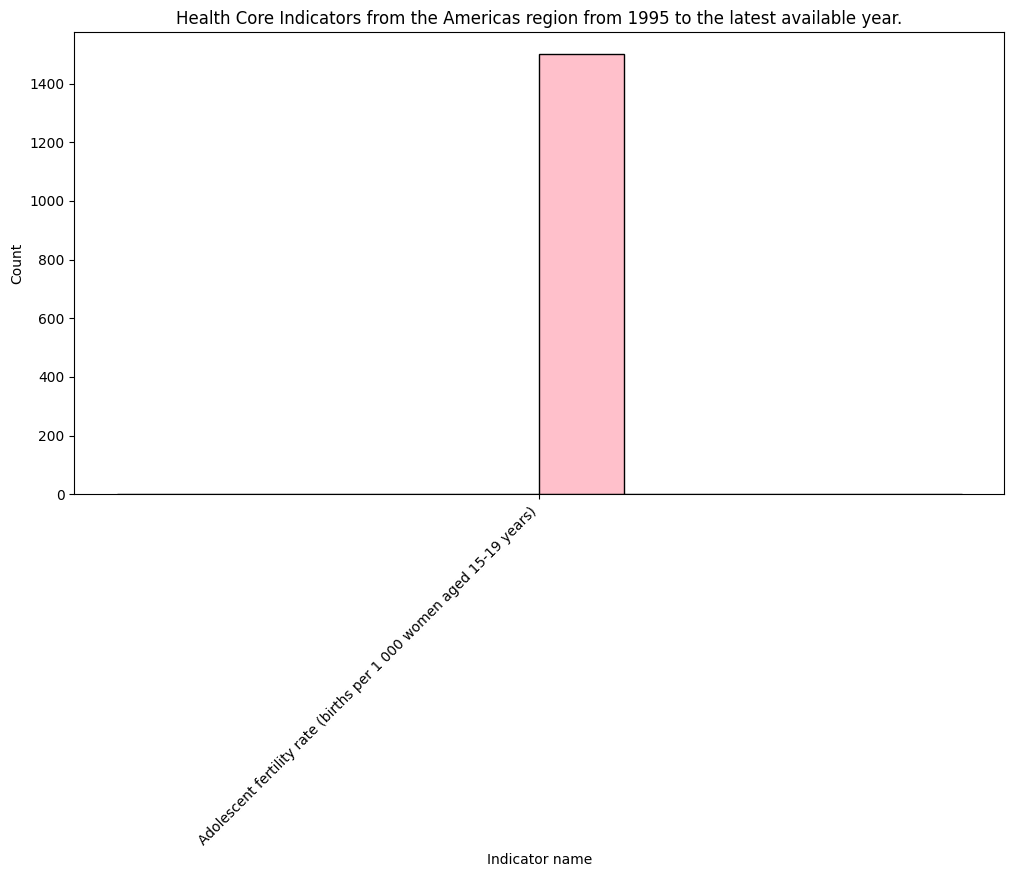

In [283]:
# Histogram for indicators

plt.figure(figsize=(12,6))
plt.hist(df_original['indicator_name'].head(1500),color='pink',edgecolor='black')
plt.xlabel('Indicator name')
plt.ylabel('Count')

plt.xticks(rotation=45,ha='right',fontsize=10)
plt.title('Health Core Indicators from the Americas region from 1995 to the latest available year.')
plt.show()

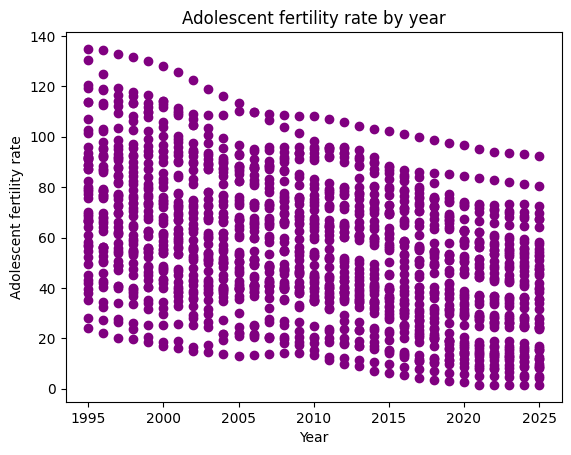

In [284]:
# scatter plot "numeric value" (indicator rate)

plt.figure()
plt.scatter(df_original["time_dim"].head(1500), df_original["numeric_value"].head(1500),color='purple')
plt.xlabel("Year")
plt.ylabel("Adolescent fertility rate")
plt.title("Adolescent fertility rate by year")
plt.show()


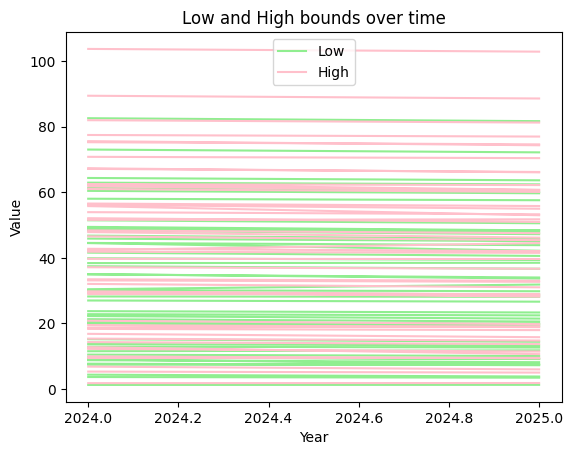

In [285]:
# plot high and low

plt.figure()
plt.plot(df_original["time_dim"].head(1500), df_original["low"].head(1500), label="Low",color='lightgreen')
plt.plot(df_original["time_dim"].head(1500), df_original["high"].head(1500), label="High",color='pink')

plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Low and High bounds over time")
plt.legend()
plt.show()


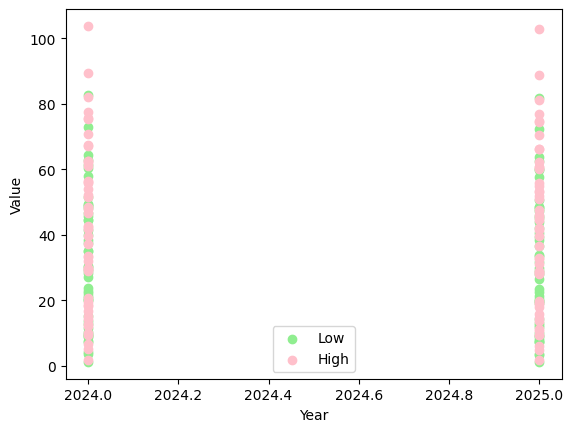

In [286]:
plt.figure()
plt.scatter(df_original["time_dim"].head(1500), df_original["low"].head(1500), label="Low",color='lightgreen')
plt.scatter(df_original["time_dim"].head(1500), df_original["high"].head(1500), label="High",color='pink')

plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.show()


In [287]:
df_original[["numeric_value", "low", "high"]].head(1500).isna().sum()


,0
numeric_value,0
low,1404
high,1404


In [288]:
df_clean = df_original.dropna()

In [289]:
df_clean[["numeric_value", "low", "high"]].head(1500).isna().sum()


,0
numeric_value,0
low,0
high,0


## Sphering

In [290]:
variables = ["numeric_value", "low", "high"]

X = df_original[variables].head(1500).dropna().values

xc​=x−mean(x) Center the data

In [291]:
mu = X.mean(axis=0)
Xc = X - mu

In [292]:
cov = np.cov(Xc, rowvar=False) # covariance matrix

Σ=QΛQT Eigen decomposition

In [293]:
eigvals, eigvecs = np.linalg.eigh(cov)

Λ−1/2=diag(1/λ
​)

In [294]:
eps = 1e-10
Lambda_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals + eps))

Using sphering formula

In [295]:
Z = (Lambda_inv_sqrt @ eigvecs.T @ Xc.T).T

include sphered values to the original dataset

In [296]:
df_sphered = df_original.loc[df_original[variables].head(1500).dropna().index].copy()

df_sphered[[v + "_sphered" for v in variables]] = Z

Plot the sphered values

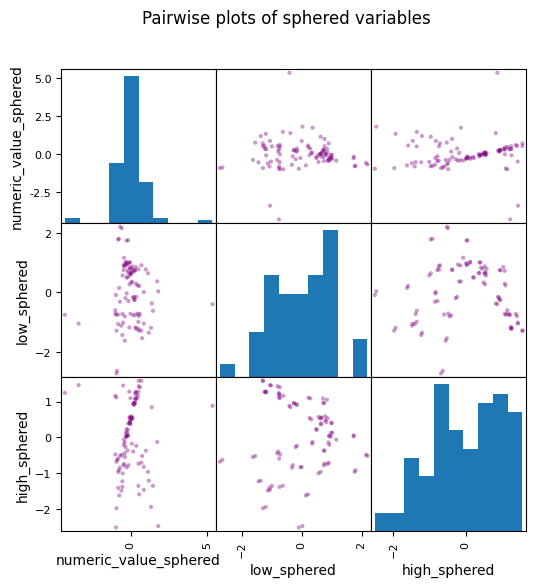

In [297]:
pd.plotting.scatter_matrix(
    df_sphered[
        ["numeric_value_sphered", "low_sphered", "high_sphered"]
    ],
    figsize=(6, 6),
    diagonal="hist",
    alpha=0.4,
    color="purple"
)

plt.suptitle("Pairwise plots of sphered variables")
plt.show()


original values

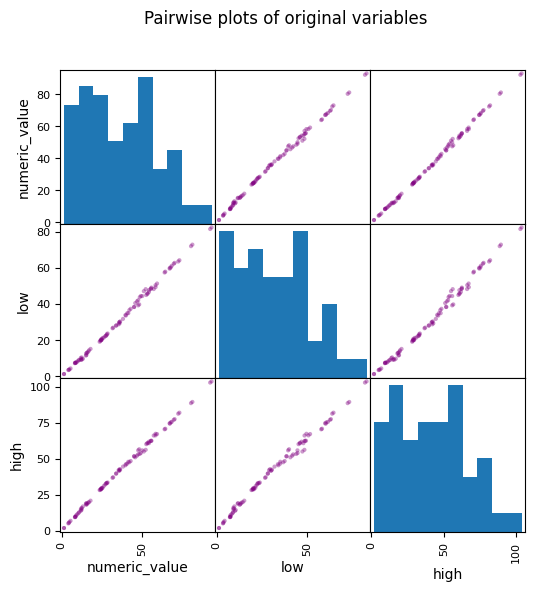

In [298]:
pd.plotting.scatter_matrix(
    df_sphered[
        ["numeric_value", "low", "high"]
    ].head(1500),
    figsize=(6, 6),
    diagonal="hist",
    alpha=0.4,
    color="purple"
)

plt.suptitle("Pairwise plots of original variables")
plt.show()


## Cosine similarity matrix

In [299]:

Z = df_sphered[["numeric_value_sphered", "low_sphered", "high_sphered"]].head(1500).values

In [300]:
Z_norm = Z / np.linalg.norm(Z, axis=1, keepdims=True) # keepdims to have the right shape (96,1) instead of (96,)
cosine_similarity = Z_norm @ Z_norm.T


In [301]:
cov_Z = np.cov(Z, rowvar=False) # covariance matrix

In [302]:
eigvals, eigvecs = np.linalg.eigh(cov_Z) # eigenvalues and vectors

In [303]:
largest_3_eigvals = np.sort(eigvals)[-3:][::-1]
largest_3_eigvals

array([1.       , 1.       , 0.9999956])

## Transform long format to wide and handle missing values

### long to wide format

keep important fatures

In [304]:
df_clean = df_original[["spatial_dim_en", "time_dim", "indicator_name", "numeric_value"]]

df_clean = df_clean.rename(columns={
    "spatial_dim_en": "country",
    "time_dim": "year",
    "indicator_name": "indicator",
    "numeric_value": "value"
})


In [305]:
df_clean.head()

,country,year,indicator,value
0,Aruba,1995,Adolescent fertility rate (births per 1 000 wo...,43.239
1,Aruba,1996,Adolescent fertility rate (births per 1 000 wo...,41.874
2,Aruba,1997,Adolescent fertility rate (births per 1 000 wo...,40.793
3,Aruba,1998,Adolescent fertility rate (births per 1 000 wo...,38.001
4,Aruba,1999,Adolescent fertility rate (births per 1 000 wo...,40.549


In [306]:
df_clean.isna().sum()

,0
country,0
year,0
indicator,0
value,0


In [307]:
df_year = df_clean[df_clean['year'] == 1999] # choosing a year to apply the clustering

In [308]:
df_year.head()

,country,year,indicator,value
4,Aruba,1999,Adolescent fertility rate (births per 1 000 wo...,40.549
35,Anguilla,1999,Adolescent fertility rate (births per 1 000 wo...,55.772
66,Argentina,1999,Adolescent fertility rate (births per 1 000 wo...,67.391
97,Antigua and Barbuda,1999,Adolescent fertility rate (births per 1 000 wo...,55.917
128,Bahamas,1999,Adolescent fertility rate (births per 1 000 wo...,45.073


In [309]:
df_year.isna().sum()

,0
country,0
year,0
indicator,0
value,0


In case the same row, column combination appears more than once will be filled up with the mean (using aggregation function)

In [310]:
df_wide = df_year.pivot_table(
    index='country',
    columns='indicator',
    values='value',
    aggfunc='mean'
)

In [311]:
df_wide.shape

(49, 144)

In [312]:
df_wide.head()

indicator,Adolescent fertility rate (births per 1 000 women aged 15-19 years),Annual GDP growth (%),Annual population growth rate (%),Antenatal care coverage -at least 4 visits (%),Births (thousands),Births attended by skilled health personnel (%),"Contraceptive prevalence use, modern methods (%)",Contraceptive prevalence use; modern methods (%); married or in union women,Contraceptive prevalence use; modern methods (%); unmarried women,Crude birth rate (1 000 pop),...,Under-five mortality (1 000 lb),Unemployment rate (%),Unemployment rate (%); female,Unemployment rate (%); male,Urban Population (%),Wild poliomyelities cases,Women accessing prenatal care since the first trimester (%),Youth literacy rate (%),Youth literacy rate; female,Youth literacy rate; male
country,,,,,,,,,,,,,,,,,,,,,
Anguilla,55.772,NaN,2.970,NaN,0.173,NaN,26.2,39.8,16.0,15.994,...,NaN,NaN,NaN,NaN,100.000,0.0,NaN,NaN,NaN,NaN
Antigua and Barbuda,55.917,3.707746,1.658,NaN,1.303,NaN,30.1,51.1,16.2,17.687,...,NaN,NaN,NaN,NaN,32.490,0.0,NaN,NaN,NaN,NaN
Argentina,67.391,-3.385457,1.152,NaN,722.777,99.0,42.0,58.7,21.3,19.644,...,20.5,14.05,15.154,13.258,88.952,0.0,44.6,NaN,NaN,NaN
Aruba,40.549,1.238042,3.124,NaN,1.239,NaN,NaN,NaN,NaN,14.324,...,8.8,NaN,NaN,NaN,47.127,NaN,NaN,NaN,NaN,NaN
Bahamas,45.073,7.144104,1.287,NaN,5.772,99.0,33.3,57.6,16.2,18.061,...,18.1,7.45,9.351,5.801,81.824,0.0,NaN,NaN,NaN,NaN


In [313]:
df_wide.isna().sum()

,0
indicator,
Adolescent fertility rate (births per 1 000 women aged 15-19 years),0
Annual GDP growth (%),11
Annual population growth rate (%),0
Antenatal care coverage -at least 4 visits (%),45
Births (thousands),0
...,...
Wild poliomyelities cases,8
Women accessing prenatal care since the first trimester (%),42
Youth literacy rate (%),48


In [314]:
print("Count of missing per column:\n",df_wide.isna().sum())
print("\n\n-----------------------------")
print("\n\nProportion of missing per column:\n",df_wide.isna().mean())

Count of missing per column:
 indicator
Adolescent fertility rate (births per 1 000 women aged 15-19 years)     0
Annual GDP growth (%)                                                  11
Annual population growth rate (%)                                       0
Antenatal care coverage -at least 4 visits (%)                         45
Births (thousands)                                                      0
                                                                       ..
Wild poliomyelities cases                                               8
Women accessing prenatal care since the first trimester (%)            42
Youth literacy rate (%)                                                48
Youth literacy rate; female                                            48
Youth literacy rate; male                                              48
Length: 144, dtype: int64


-----------------------------


Proportion of missing per column:
 indicator
Adolescent fertility rate (births per 1 0

### Using different maps to check there are any patterns in missingness after pivoting

<Axes: >

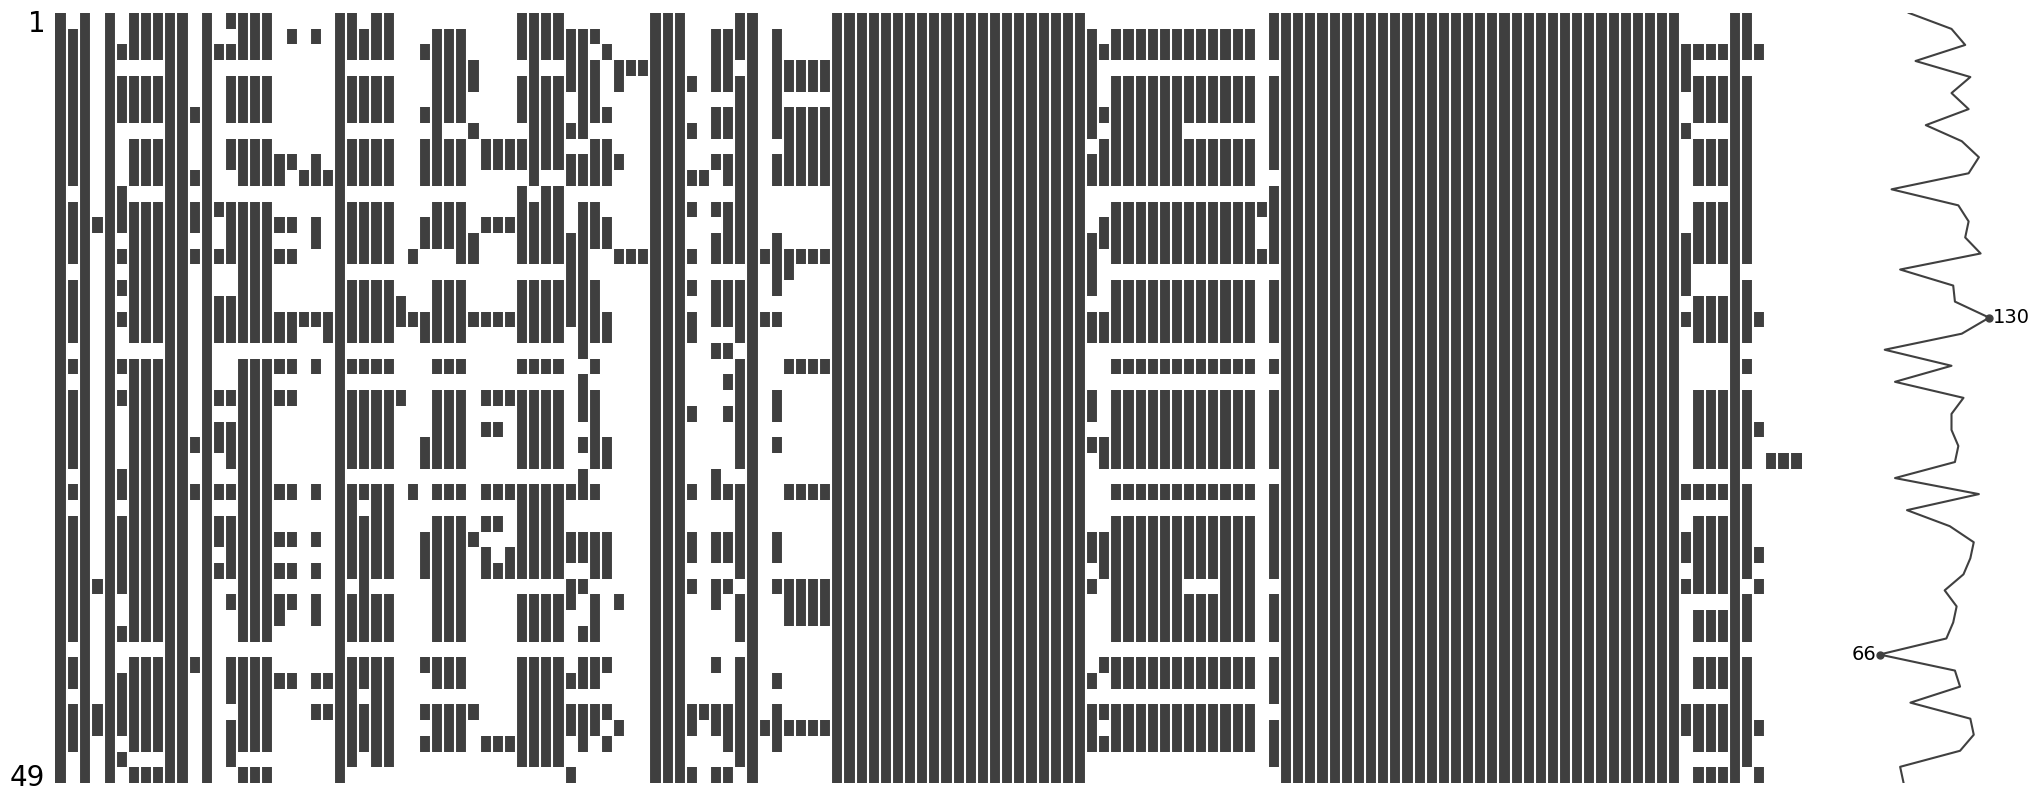

In [315]:
msno.matrix(df_wide)

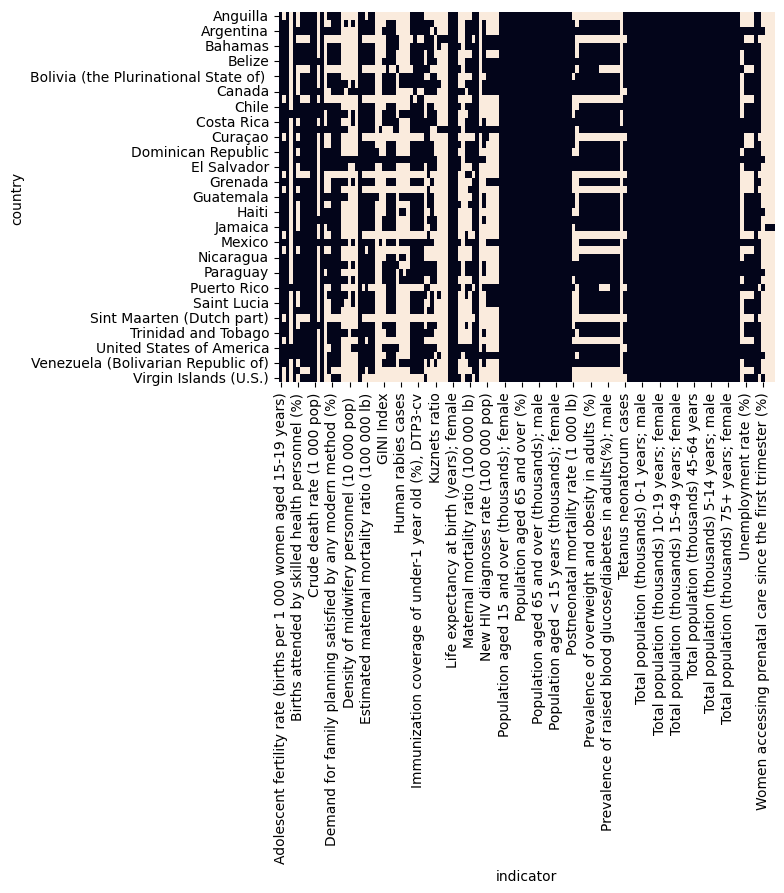

In [316]:
sns.heatmap(df_wide.isna(),cbar=False)
plt.show()

In [317]:
df_wide.isna().sum().sum()

np.int64(1922)

### Remove the indicators with a lot of missing values (>40%)

In [318]:
df_wide = df_wide.dropna(axis=1,thresh=0.6*len(df_wide))

In [319]:
df_wide.isna().mean()

,0
indicator,
Adolescent fertility rate (births per 1 000 women aged 15-19 years),0.000000
Annual GDP growth (%),0.224490
Annual population growth rate (%),0.000000
Births (thousands),0.000000
"Contraceptive prevalence use, modern methods (%)",0.122449
...,...
Unemployment rate (%),0.326531
Unemployment rate (%); female,0.326531
Unemployment rate (%); male,0.326531


### Fill the rest of the missing values with median. In case of using all the years the missing values could have been filled by considering the values within the years.

??Another technique to consider in this case would be to impute the missings values by using the IterativeImputer library?

Using median to fill missing values to robust skewness. The mean can make the countries more similar than they are (affects the variance)

In [320]:
df_wide = df_wide.fillna(df_wide.median())

In [321]:
df_wide.isna().sum().sum()

np.int64(0)

In [322]:
df_wide.shape

(49, 105)

# Process before clustering

## Scaling the values

In [323]:
df_wide.isna().sum().sum() # double check if there are missing values before clustering

np.int64(0)

In [324]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_wide)

In [325]:
df_scaled = pd.DataFrame(X_scaled,
                         index=df_wide.index,
                         columns=df_wide.columns
                         )

In [326]:
df_scaled.head()

indicator,Adolescent fertility rate (births per 1 000 women aged 15-19 years),Annual GDP growth (%),Annual population growth rate (%),Births (thousands),"Contraceptive prevalence use, modern methods (%)",Contraceptive prevalence use; modern methods (%); married or in union women,Contraceptive prevalence use; modern methods (%); unmarried women,Crude birth rate (1 000 pop),Crude death rate (1 000 pop),Deaths (thousands),...,Total population (thousands) 75+ years,Total population (thousands) 75+ years; female,Total population (thousands) 75+ years; male,Total population (thousands); female,Total population (thousands); male,Unemployment rate (%),Unemployment rate (%); female,Unemployment rate (%); male,Urban Population (%),Wild poliomyelities cases
country,,,,,,,,,,,,,,,,,,,,,
Anguilla,-0.514705,0.100969,0.878751,-0.409263,-0.934452,-1.060582,-0.122688,-0.772560,-0.306093,-0.316687,...,-0.243305,-0.237900,-0.252330,-0.356189,-0.356182,-0.293349,-0.216781,-0.048181,1.460192,0.0
Antigua and Barbuda,-0.509376,0.415751,0.257913,-0.407839,-0.549429,-0.140281,-0.100985,-0.503403,-0.207125,-0.315598,...,-0.242326,-0.236931,-0.251336,-0.354785,-0.354921,-0.293349,-0.216781,-0.048181,-1.383818,0.0
Argentina,-0.087641,-1.822729,0.018474,0.501237,0.625386,0.478683,0.452440,-0.192275,0.351547,0.428967,...,0.365731,0.387059,0.328994,0.428661,0.419718,1.353340,0.975832,1.402353,0.994770,0.0
Aruba,-1.074237,-0.363641,0.951624,-0.407919,-0.124916,0.079614,-0.100985,-1.038061,-0.217022,-0.315382,...,-0.242658,-0.237285,-0.251631,-0.354535,-0.354627,-0.293349,-0.216781,-0.048181,-0.767201,0.0
Bahamas,-0.907954,1.500200,0.082356,-0.402208,-0.233512,0.389096,-0.100985,-0.443944,-0.170012,-0.311291,...,-0.240195,-0.234970,-0.248917,-0.349621,-0.349649,-0.293349,-0.237693,-0.588927,0.694487,0.0


In [327]:
df_scaled.isna().sum().sum() # checking if there are missing values after clustering

np.int64(0)

In [328]:
pca = PCA()                         # apply pca
X_pca = pca.fit_transform(X_scaled)

Using cumulative explained variance to decide the number of components

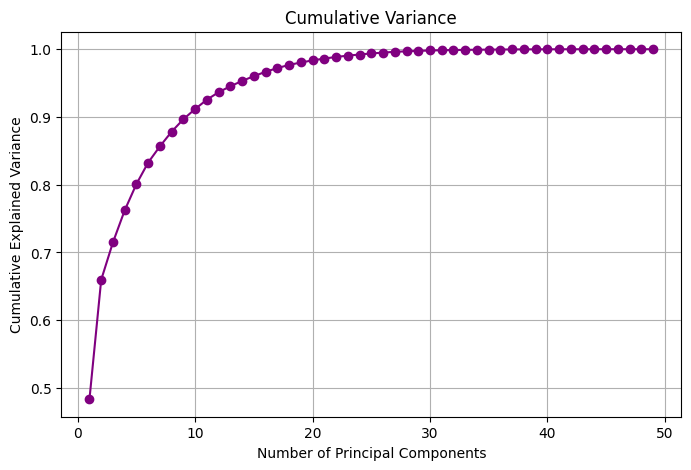

In [329]:
cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o',color='purple')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance')
plt.grid(True)
plt.show()

10 components explain 90% of variance so it's reasonable number, right? Is it okay for health indicators? Or it should be higher?

In [330]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

In [331]:
X_pca.shape

(49, 10)

In [332]:
X_pca

array([[-2.37595839e+00, -1.99672359e+00, -3.91877582e-01,
        -2.59210141e-01, -1.10342108e+00,  8.39402963e-01,
         1.79855011e+00,  9.79857929e-03, -1.88626998e+00,
        -4.84653737e-01],
       [-1.71008897e+00, -3.24096477e+00, -8.17054606e-01,
         1.61610509e+00,  6.21915428e-01,  8.14972271e-01,
         3.11803648e-02,  1.34430300e+00, -9.99368408e-01,
         2.25348229e+00],
       [ 3.42879734e+00, -9.54026427e-01,  1.61246645e+00,
        -2.72302533e+00,  1.30324478e+00,  7.52359929e-01,
         4.31386306e-01, -1.48188137e+00,  2.00418375e+00,
        -7.08141075e-01],
       [-1.62281085e+00, -3.56933842e+00, -1.76251320e+00,
         2.16708972e-01,  2.12587048e-01, -1.38623814e+00,
         1.20046504e+00,  1.19667977e-01,  8.81743724e-01,
         2.39231187e+00],
       [-1.34463719e+00, -4.38276392e+00,  1.13703583e+00,
         4.10468506e+00,  2.80749965e+00, -6.76295644e-01,
         2.07899814e+00,  1.23130512e+00,  2.67645009e+00,
         1.

# Agglomerative Clustering

Using silhouette score to choose the number of clusters 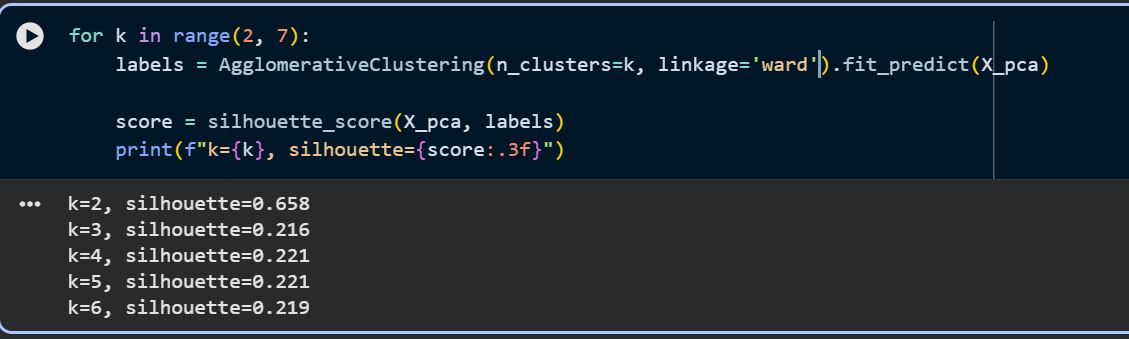

In [333]:
for k in range(2, 7):
    labels = AgglomerativeClustering(n_clusters=k, linkage='ward').fit_predict(X_pca)

    score = silhouette_score(X_pca, labels)
    print(f"k={k}, silhouette={score:.3f}")

k=2, silhouette=0.658
k=3, silhouette=0.216
k=4, silhouette=0.221
k=5, silhouette=0.221
k=6, silhouette=0.219


When choosing clusters (2 clusters)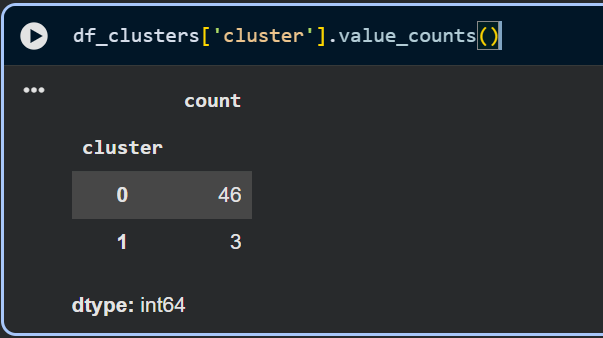

When choosing 'average' as linkage function 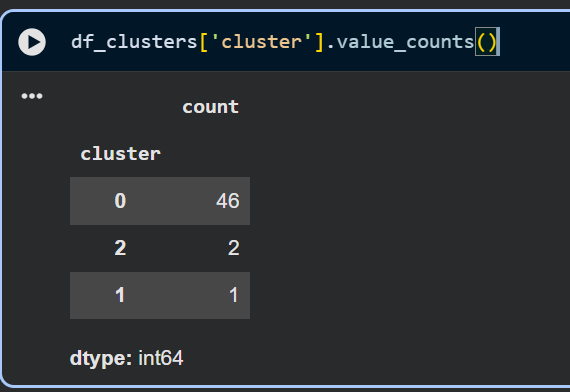

In [334]:
agg_clustering = AgglomerativeClustering(n_clusters=3,linkage='ward')
labels = agg_clustering.fit_predict(X_pca)

In [335]:
df_clusters = df_scaled.copy()
df_clusters['cluster'] = labels

In [336]:
df_clusters['cluster'].value_counts()

,count
cluster,
2,24
1,22
0,3


In [337]:
cluster_members = pd.DataFrame({'country': df_scaled.index,  'cluster': labels}) # cluster mapping

cluster_members.set_index('country', inplace=True) # country->index
cluster_members.head()

,cluster
country,
Anguilla,2
Antigua and Barbuda,2
Argentina,1
Aruba,2
Bahamas,2


In [338]:
countries_per_cluster = cluster_members.groupby('cluster').apply(lambda x: list(x.index))
print(countries_per_cluster)

cluster
0           [Brazil, Mexico, United States of America]
1    [Argentina, Belize, Bolivia (the Plurinational...
2    [Anguilla, Antigua and Barbuda, Aruba, Bahamas...
dtype: object


/tmp/ipython-input-2692786134.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  countries_per_cluster = cluster_members.groupby('cluster').apply(lambda x: list(x.index))


In [364]:
for c, countries in countries_per_cluster.items():     # all the countries included in the clusters
    print(f"\nCluster {c} ({len(countries)} countries):")
    print(", ".join(countries))


Cluster 0 (3 countries):
Brazil, Mexico, United States of America

Cluster 1 (22 countries):
Argentina, Belize, Bolivia (the Plurinational State of) , Colombia, Costa Rica, Dominican Republic, Ecuador, El Salvador, French Guiana, Guatemala, Guyana, Haiti, Honduras, Jamaica, Nicaragua, Panama, Paraguay, Peru, Saint Lucia, Saint Vincent and the Grenadines, Suriname, Venezuela (Bolivarian Republic of)

Cluster 2 (24 countries):
Anguilla, Antigua and Barbuda, Aruba, Bahamas, Barbados, Bermuda, Canada, Cayman Islands , Chile, Cuba, Curaçao, Dominica, Grenada, Guadeloupe, Martinique, Montserrat, Puerto Rico, Saint Kitts and Nevis, Sint Maarten (Dutch part), Trinidad and Tobago, Turks and Caicos Islands, Uruguay, Virgin Islands (British), Virgin Islands (U.S.)


In [340]:
agg_clusters = pd.DataFrame(
    X_pca[:, :2],
    columns=['PC1', 'PC2'],
    index=df_scaled.index
)

agg_clusters['cluster'] = labels

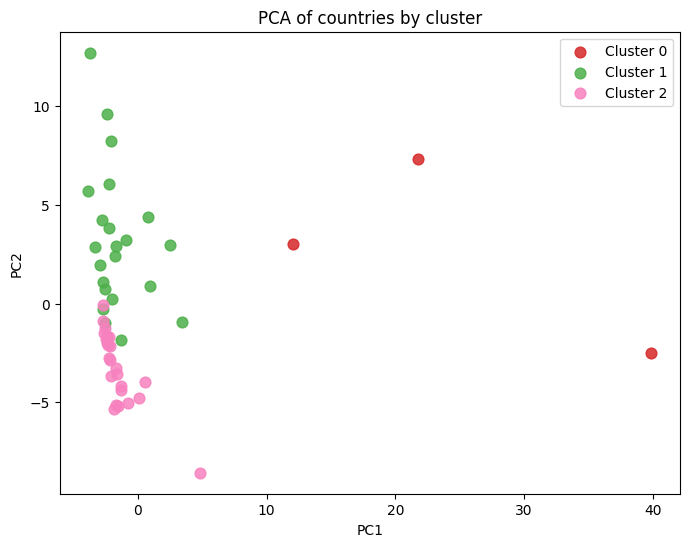

In [341]:
cluster_colors = {
    0: '#D62728',
    1: '#4DAF4A',
    2: '#F781BF'
}
plt.figure(figsize=(8, 6))

for c in sorted(agg_clusters['cluster'].unique()):
    subset = agg_clusters[agg_clusters['cluster'] == c]
    plt.scatter(
        subset['PC1'],
        subset['PC2'],
        color=cluster_colors[c],
        label=f'Cluster {c}',
        s=60,
        alpha=0.85
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('PCA of countries by cluster')
plt.show()

# Kmeans

In [342]:
kmeans = KMeans(n_clusters=3)
km_labels = kmeans.fit_predict(X_pca)

In [343]:
km_clusters = df_scaled.copy()
km_clusters['cluster'] = km_labels

In [344]:
km_clusters['cluster'].value_counts()

,count
cluster,
0,32
2,14
1,3


In [345]:
km_clusters = pd.DataFrame(
    X_pca[:, :2],
    columns=['PC1', 'PC2'],
    index=df_scaled.index
)
km_clusters['cluster'] = km_labels

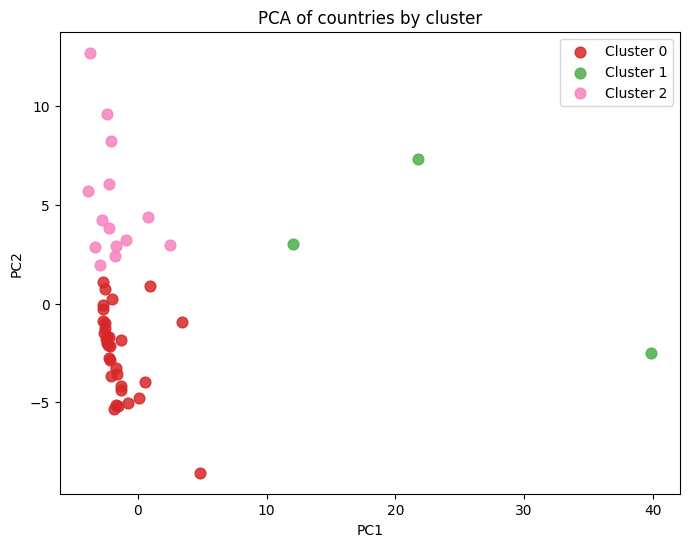

In [346]:
cluster_colors = {
    0: '#D62728',
    1: '#4DAF4A',
    2: '#F781BF'
}
plt.figure(figsize=(8, 6))

for c in sorted(km_clusters['cluster'].unique()):
    subset = km_clusters[km_clusters['cluster'] == c]
    plt.scatter(
        subset['PC1'],
        subset['PC2'],
        color=cluster_colors[c],
        label=f'Cluster {c}',
        s=60,
        alpha=0.85
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('PCA of countries by cluster')
plt.show()

# Gaussian Mixture Clustering

## 2 clusters

In [347]:
gm = GaussianMixture(n_components=2)
gm_labels = gm.fit_predict(X_pca)

In [348]:
gm_clusters = df_scaled.copy()
gm_clusters['cluster'] = gm_labels

In [349]:
gm_clusters['cluster'].value_counts()

,count
cluster,
0,47
1,2


In [350]:
gm_clusters = pd.DataFrame(
    X_pca[:, :2],
    columns=['PC1', 'PC2'],
    index=df_scaled.index
)

gm_clusters['cluster'] = gm_labels

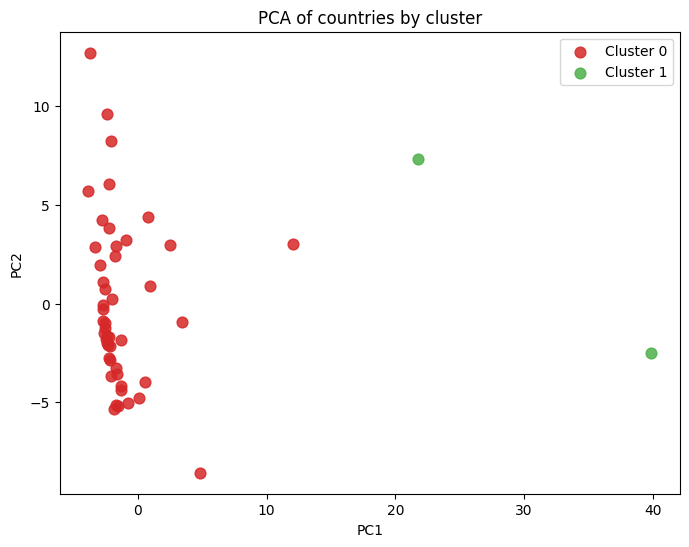

In [351]:
cluster_colors = {
    0: '#D62728',
    1: '#4DAF4A',
    2: '#F781BF'
}
plt.figure(figsize=(8, 6))

for c in sorted(gm_clusters['cluster'].unique()):
    subset = gm_clusters[gm_clusters['cluster'] == c]
    plt.scatter(
        subset['PC1'],
        subset['PC2'],
        color=cluster_colors[c],
        label=f'Cluster {c}',
        s=60,
        alpha=0.85
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('PCA of countries by cluster')
plt.show()

In [352]:
cluster_members = pd.DataFrame({'country': df_scaled.index,  'cluster': gm_labels}) # cluster mapping

cluster_members.set_index('country', inplace=True) # set country as index again
countries_by_cluster = cluster_members.groupby('cluster').apply(lambda x: list(x.index))
print(countries_by_cluster)

cluster
0    [Anguilla, Antigua and Barbuda, Argentina, Aru...
1                   [Brazil, United States of America]
dtype: object


/tmp/ipython-input-115301731.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  countries_by_cluster = cluster_members.groupby('cluster').apply(lambda x: list(x.index))


## 3 clusters

In [353]:
gm3 = GaussianMixture(n_components=3)
gm_labels3 = gm3.fit_predict(X_pca)

In [354]:
gm_clusters3 = df_scaled.copy()
gm_clusters3['cluster'] = gm_labels3

In [355]:
gm_clusters3['cluster'].value_counts()

,count
cluster,
0,46
2,2
1,1


In [356]:
gm_clusters3 = pd.DataFrame(
    X_pca[:, :2],
    columns=['PC1', 'PC2'],
    index=df_scaled.index
)

gm_clusters3['cluster'] = gm_labels3

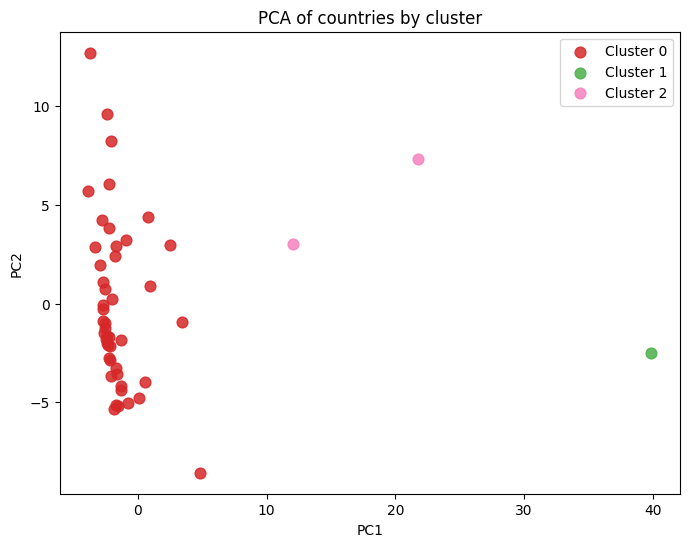

In [357]:
cluster_colors = {
    0: '#D62728',
    1: '#4DAF4A',
    2: '#F781BF'
}
plt.figure(figsize=(8, 6))

for c in sorted(gm_clusters3['cluster'].unique()):
    subset = gm_clusters3[gm_clusters3['cluster'] == c]
    plt.scatter(
        subset['PC1'],
        subset['PC2'],
        color=cluster_colors[c],
        label=f'Cluster {c}',
        s=60,
        alpha=0.85
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('PCA of countries by cluster')
plt.show()

In [358]:
cluster_members3 = pd.DataFrame({'country': df_scaled.index,  'cluster': gm_labels3}) # cluster mapping

cluster_members3.set_index('country', inplace=True) # set country as index again
countries_by_cluster3 = cluster_members3.groupby('cluster').apply(lambda x: list(x.index))
print(countries_by_cluster3)

cluster
0    [Anguilla, Antigua and Barbuda, Argentina, Aru...
1                           [United States of America]
2                                     [Brazil, Mexico]
dtype: object


/tmp/ipython-input-1103071021.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  countries_by_cluster3 = cluster_members3.groupby('cluster').apply(lambda x: list(x.index))


# DBScan (I did not get deep into it. I was curious to see what kind of results it will give)

In [359]:
dbscan = DBSCAN(eps=1.1, min_samples=3)
db_labels = dbscan.fit_predict(X_pca)

In [360]:
db_clusters = df_scaled.copy()
db_clusters['clusters'] = db_labels

In [361]:
db_clusters['clusters'].value_counts()

,count
clusters,
-1,49


# XAI

# Using Agglomerative Clustering labels

The mean value of every indicator across all countries in that cluster.
->0 = global average across all countries
->Positive values = above average
->Negative values = below average

In [362]:
cluster_means = df_scaled.copy()
cluster_means['cluster'] = labels

cluster_final = cluster_means.groupby('cluster').mean()
cluster_final


indicator,Adolescent fertility rate (births per 1 000 women aged 15-19 years),Annual GDP growth (%),Annual population growth rate (%),Births (thousands),"Contraceptive prevalence use, modern methods (%)",Contraceptive prevalence use; modern methods (%); married or in union women,Contraceptive prevalence use; modern methods (%); unmarried women,Crude birth rate (1 000 pop),Crude death rate (1 000 pop),Deaths (thousands),...,Total population (thousands) 75+ years,Total population (thousands) 75+ years; female,Total population (thousands) 75+ years; male,Total population (thousands); female,Total population (thousands); male,Unemployment rate (%),Unemployment rate (%); female,Unemployment rate (%); male,Urban Population (%),Wild poliomyelities cases
cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.011287,0.088404,0.092924,3.705891,1.448085,1.130223,0.969693,-0.182683,-0.024200,3.275744,...,2.734793,2.684349,2.818643,3.521300,3.510291,-0.659945,-0.611112,-0.803623,0.528885,0.0
1,0.864269,-0.284087,0.296070,-0.110860,-0.182804,-0.166935,-0.366353,0.873442,-0.233464,-0.157910,...,-0.166636,-0.163931,-0.171115,-0.156609,-0.154996,0.157007,0.126842,0.070820,-0.338268,0.0
2,-0.790835,0.249362,-0.283013,-0.361614,-0.013440,0.011745,0.214612,-0.777820,0.217034,-0.264717,...,-0.189100,-0.185274,-0.195475,-0.296604,-0.296706,-0.061430,-0.039883,0.035535,0.243968,0.0


Significant indicators per cluster

In [363]:
for cluster_id, row in cluster_final.iterrows():
    print(f"\nCluster {cluster_id}")


    above_avg = row.sort_values(ascending=False).head(10) # 10 indicators above average
    print("\nAbove average:")
    for i, (feature, value) in enumerate(above_avg.items()):
        print(f"{i+1}. {feature}: {value:.2f}")

    below_avg = row.sort_values().head(10)                # 10 indicators below average
    print("\nBelow average:")
    for j, (feature, value) in enumerate(below_avg.items()):
        print(f"{j+1}.{feature}: {value:.2f}")



Cluster 0

Above average:
1. Births (thousands): 3.71
2. Population aged < 5 years (thousands); female: 3.70
3. Total population (thousands) 0-1 years; female: 3.70
4. Total population (thousands) 1-4 years; female: 3.70
5. Total population (thousands) 0-1 years: 3.70
6. Population aged < 5 years (thousands): 3.70
7. Total population (thousands) 1-4 years: 3.70
8. Total population (thousands) 0-1 years; male: 3.70
9. Population aged < 5 years (thousands); male: 3.69
10. Population aged < 15 years (thousands); female: 3.69

Below average:
1.Unemployment rate (%); male: -0.80
2.Unemployment rate (%): -0.66
3.Unemployment rate (%); female: -0.61
4.Estimated maternal mortality ratio (100 000 lb): -0.60
5.Prevalence of raised blood pressure in adults (%); female: -0.58
6.Prevalence of raised blood glucose/diabetes in adults(%); female: -0.57
7.Prevalence of raised blood pressure in adults (%): -0.53
8.Prevalence of raised blood pressure in adults (%); male: -0.43
9.Immunization coverage of